In [1]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j


class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [3]:
def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()

In [4]:
def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))

In [5]:
def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        train_acc = test(data)
        test_acc = test(data, train=False)
        if len(test_accuracies) > 0:
            if (test_acc > test_accuracies[-1]):
                torch.save(model, "./PubMed_best_GCN.pth")
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        
        print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
              format(epoch, loss, train_acc, test_acc))
        
    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

Processing...
Done!
/home/nightbaron/Documents/code/UCR/IDL/EECS228_Graph_Transferability/.venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


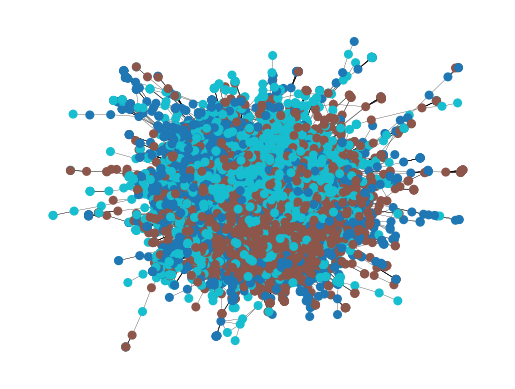

Epoch: 000, Loss: 1.10932, Train Acc: 0.33333, Test Acc: 0.41300
Epoch: 001, Loss: 1.10178, Train Acc: 0.33333, Test Acc: 0.41300
Epoch: 002, Loss: 1.09563, Train Acc: 0.33333, Test Acc: 0.41300
Epoch: 003, Loss: 1.08411, Train Acc: 0.33333, Test Acc: 0.41300
Epoch: 004, Loss: 1.07327, Train Acc: 0.33333, Test Acc: 0.41400
Epoch: 005, Loss: 1.05480, Train Acc: 0.48333, Test Acc: 0.43700
Epoch: 006, Loss: 1.04542, Train Acc: 0.63333, Test Acc: 0.54200
Epoch: 007, Loss: 1.03877, Train Acc: 0.75000, Test Acc: 0.60600
Epoch: 008, Loss: 1.02507, Train Acc: 0.80000, Test Acc: 0.64000
Epoch: 009, Loss: 0.99284, Train Acc: 0.80000, Test Acc: 0.65900
Epoch: 010, Loss: 0.98640, Train Acc: 0.83333, Test Acc: 0.67300
Epoch: 011, Loss: 0.95961, Train Acc: 0.81667, Test Acc: 0.68000
Epoch: 012, Loss: 0.94995, Train Acc: 0.83333, Test Acc: 0.67300
Epoch: 013, Loss: 0.94980, Train Acc: 0.85000, Test Acc: 0.67300
Epoch: 014, Loss: 0.90645, Train Acc: 0.88333, Test Acc: 0.66600
Epoch: 015, Loss: 0.91397

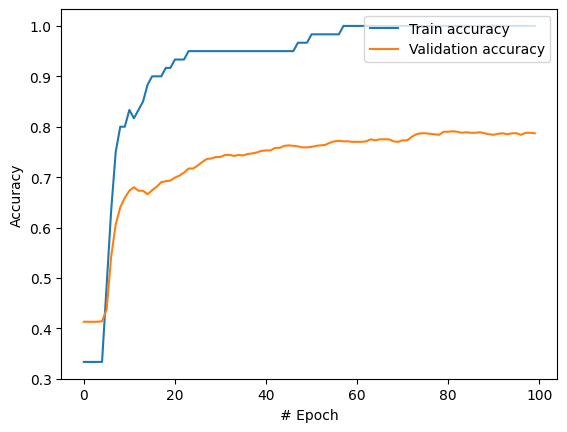

In [6]:
dataset_list = ["Cora", "PubMed"]

# print("Training on {}".format(data))
dataset = Planetoid(root='./data', name="PubMed")



plot_dataset(dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train(data, plot=True)